In [616]:
import sys
sys.path.append('../..')

In [617]:
import pathlib

import numpy
import numpy.fft

import scipy.signal

import PIL.Image

import lasp.io
import lasp.filters.linear
import lasp.utils
import lasp.noise


In [618]:
import scipy.io.matlab

def cmp_py_mat(var_name: str, var_py) -> None:
    mat = scipy.io.matlab.loadmat(pathlib.Path('./{}.mat'.format(var_name)))
    matlab = mat[var_name]
    print(var_name, ':', numpy.max(numpy.abs(var_py-matlab)))
datas = {}

In [619]:
refl = lasp.io.read(pathlib.Path('lena.bmp'))
refl = refl.astype(numpy.double)
datas['refl'] = numpy.copy(refl)
print(refl.shape)

(512, 512)


In [620]:
B = lasp.filters.linear.gaussian_filter(9, 3)
datas['B'] = numpy.copy(B)


nb_rows, nb_cols = B.shape
kernel_padded = numpy.zeros(refl.shape)
kernel_padded[:nb_rows, :nb_cols] = numpy.copy(B)
center = numpy.floor(numpy.array(B.shape)/2).astype(int) + 1
circshifted = lasp.utils.circshift(kernel_padded, 1-center)

FB = numpy.fft.fft2(circshifted)

# HXconv
#FB = fourier_diagonalization(B, refl.shape)
FBC = numpy.conj(FB)
F2B = numpy.abs(FB)**2
print(FB.shape, FBC.shape, F2B.shape)

#Bx n'a d'intêret que pour le bruitage du signal
#Bx = numpy.real(FB*numpy.fft.fft2(refl))

(512, 512) (512, 512) (512, 512)


In [621]:
cmp_py_mat('FB', FB)
cmp_py_mat('FBC', FBC)
cmp_py_mat('F2B', F2B)

FB : 2.319436584236185e-16
FBC : 2.319436584236185e-16
F2B : 3.3306690738754696e-16


In [622]:
# On saute la partie bruitage
# Dans le code matlab, la décimation s'effectue après le bruitage
## Bruiter le signal en python
#snr = 10
Bx = scipy.signal.convolve2d(refl, B, mode='same')
#y = lasp.noise.awgn(Bx, snr)
y = Bx
datas['y'] = numpy.copy(y)

In [623]:
def decimation(image: numpy.ndarray, d_row: int, d_col: int) -> numpy.ndarray:
    if d_row <= 0:
        raise AssertionError('d_row <= 0')
    if d_col <= 0:
        raise AssertionError('d_col <= 0')
    return numpy.copy(image[0::d_row, 0::d_col])

d = 4
datas['d'] = d
dr = d
dc = d
y = decimation(y, dr, dc)

yinp = numpy.array(
    PIL.Image.Image.resize(
        PIL.Image.fromarray(y), 
        (refl.shape[1], refl.shape[0]), 
        PIL.Image.Resampling.BICUBIC
    )
)

datas['yinp'] = numpy.copy(yinp)

In [624]:
tau = 2e-3
datas['tau'] = tau
nr, nc = y.shape
nrup, ncup = nr*d, nc*d
Nb = dr*dc
m = nr*nc

In [625]:
tol = 1e-3
maxiter = 100
datas['tol'] = tol
datas['maxiter'] = maxiter

In [626]:
mu = 5e-3
datas['mu'] = mu
gam = tau/mu

In [627]:
dh = numpy.zeros(shape=(nrup, ncup))
dh[0, 0] = 1
dh[0, 1] = -1

dv = numpy.zeros(shape=(nrup, ncup))
dv[0, 0] = 1
dv[1, 0] = -1

print(dh.shape, dv.shape)

(512, 512) (512, 512)


In [628]:
FDH = numpy.fft.fft2(dh)
FDHC = numpy.conj(FDH)
F2DH = numpy.abs(FDH)**2

FDV = numpy.fft.fft2(dv)
FDVC = numpy.conj(FDV)
F2DV = numpy.abs(FDV)**2

c = 1e-8
F2D = F2DH + F2DV + c

In [629]:
cmp_py_mat('FDH', FDH)
cmp_py_mat('FDHC', FDHC)
cmp_py_mat('F2DH', F2DH)
print()
cmp_py_mat('FDV', FDV)
cmp_py_mat('FDVC', FDVC)
cmp_py_mat('F2DV', F2DV)
print()
cmp_py_mat('F2D', F2D)

FDH : 4.577566798522237e-16
FDHC : 4.577566798522237e-16
F2DH : 2.6645352591003757e-15

FDV : 4.577566798522237e-16
FDVC : 4.577566798522237e-16
F2DV : 2.6645352591003757e-15

F2D : 5.329070518200751e-15


In [630]:
STy = numpy.zeros(shape=(nrup, ncup))
STy[0::d, 0::d] = y
STytemp = numpy.ones(shape=(nrup, ncup))
STytemp[0::d, 0::d] = y

ind1 = (STytemp-STy) == 1
ind2 = (STytemp-STy) == 0

FBTSTy = FBC * numpy.fft.fft2(STy)

In [631]:
cmp_py_mat('STy', STy)
cmp_py_mat('STytemp', STytemp)
cmp_py_mat('FBTSTy', FBTSTy)

STy : 0.0
STytemp : 0.0
FBTSTy : 3.663910017036534e-11


In [632]:
X = numpy.copy(yinp)
#FX = numpy.fft.fft2(X)
#BX = numpy.fft.ifft2(FB*numpy.fft.fft2(X))
BX = numpy.real(numpy.fft.ifft2(FB*numpy.fft.fft2(X)))

In [633]:
#cmp_py_mat('FX', FX)
mat = scipy.io.matlab.loadmat(pathlib.Path('./BX.mat'))
matlab = numpy.array(mat['BX']).astype(numpy.double)
#cmp_py_mat('BX', BX)
#matlab[0:10, 0:10]

print('BX', ':', numpy.max(numpy.abs(BX-matlab)))

BX : 5.185631204085439e-05


In [634]:
U1 = numpy.copy(X)
U2 = numpy.copy(X)
U3 = numpy.copy(X)

D1 = numpy.zeros_like(X)
D2 = numpy.zeros_like(X)
D3 = numpy.zeros_like(X)

I_DH = FDHC / (F2DH + F2DV + F2B)
I_DV = FDVC / (F2DH + F2DV + F2B)
I_BB = FBC / (F2DH + F2DV + F2B)

In [635]:
cmp_py_mat('I_DH', I_DH)
cmp_py_mat('I_DV', I_DV)
cmp_py_mat('I_BB', I_BB)

I_DH : 9.820925191391734e-16
I_DV : 9.036560719766055e-16
I_BB : 6.728909998314484e-16


In [636]:
for i in range(0, maxiter):

    # Update X
    V1 = U1-D1
    V2 = U2-D2
    V3 = U3-D3

    FX = I_BB * numpy.fft.fft2(V1) \
        + I_DH * numpy.fft.fft2(V2) \
        + I_DV * numpy.fft.fft2(V3)
    
    #X = numpy.fft.ifft2(FX)
    X = numpy.real(numpy.fft.ifft2(FX))

    #if i == 0:
    #    print(X[0:3, 0:3])

    # Update U

    ##HX = numpy.fft.ifft2(FB*FX)
    HX = numpy.real(numpy.fft.ifft2(FB*FX))
    rr = mu*(HX+D1)
    temp1 = rr[ind1] / mu
    temp2 = (rr[ind2] + STy[ind2]) / (1+mu)
    U1[ind1] = temp1
    U1[ind2] = temp2

    #DhX = numpy.fft.ifft2(FX*FDH)
    #DvX = numpy.fft.ifft2(FX*FDV)
    DhX = numpy.real(numpy.fft.ifft2(FX*FDH))
    DvX = numpy.real(numpy.fft.ifft2(FX*FDV))
    NU1 = DhX + D2
    NU2 = DvX + D3
    NU = numpy.sqrt(NU1**2 + NU2**2)
    A = numpy.where(0 < NU-gam, NU-gam, 0)
    A = A / (A + gam)
    U2 = A*NU1
    U3 = A*NU2

    # Update D

    D1 = D1 + (HX - U1)
    D2 = D2 + (DhX - U2)
    D3 = D3 + (DvX - U3)



In [637]:
cmp_py_mat('X', X)

X : 0.0004892845150266112


In [638]:
#mat = scipy.io.matlab.loadmat(pathlib.Path('./X.mat'))
#matlab = mat['X']
#matlab[0:5, 0:5]

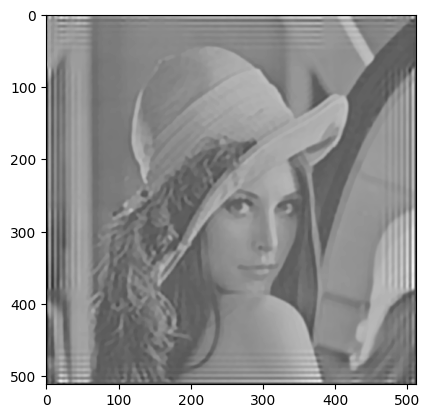

In [639]:
import matplotlib.pyplot
_ = matplotlib.pyplot.imshow(X, cmap='gray')

In [640]:
import scipy.io.matlab
scipy.io.matlab.savemat(pathlib.Path('./datas.mat'), datas)

In [641]:
lasp.io.save(X, pathlib.Path('./res.npy'))